# Employee Turnover Data XGBoost Regressor Tryout

In this tryout, we give a try to predict employees' remaining tenure by using XGBoost regressor method

In [1]:
# Loading packages

from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_preparation.clean_data import clean_data
from data_preparation.create_length_date import create_length_date
from data_preparation.data_prep import data_prep
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Data path
path = r'data\dataset.xlsx'

# Load data
df_raw = pd.read_excel(path)

# Transform data
df_clean = clean_data(df_raw)
df_clean = create_length_date(df_clean)
df_clean = data_prep(df_clean)

# Make a copy of the data to start analysis
df = df_clean.copy()

c:\Users\baran\OneDrive\Documents\GitHub\Brocacef\data_preparation\clean_data.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_temp[column] = pd.to_datetime(df_temp[column], utc=True, errors='coerce').dt.tz_localize(None)
c:\Users\baran\OneDrive\Documents\GitHub\Brocacef\data_preparation\clean_data.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_temp[column] = pd.to_datetime(df_temp[column], utc=True, errors='coerce').dt.tz_localize(None)
c:\Users\baran\OneDrive\Documents\GitHub\Brocacef\data_preparation\clean_data.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a f

Let's define the left and the stayed employees and separate the DataFrames into training and test sets.

Mean Squared Error on validation set: 32.62632861663875


c:\Users\baran\OneDrive\Documents\GitHub\Brocacef\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
C:\Users\baran\AppData\Local\Temp\ipykernel_10988\1097008559.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['Predicted_Tenure'] = predictions
C:\Users\baran\AppData\Local\Temp\ipykernel_10988\1097008559.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

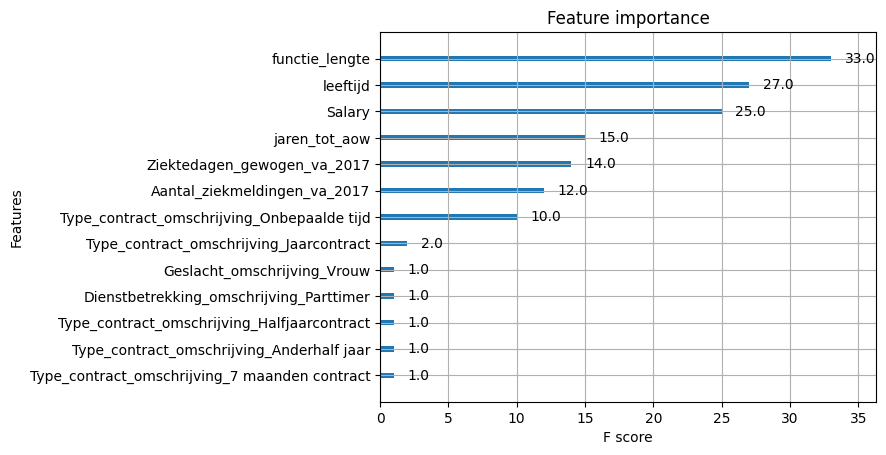

       Medewerker_code  Predicted_Tenure
0                    6          6.274559
1                   37          5.520107
3                   48          6.777472
4                   61          5.438911
5                   75          5.563700
...                ...               ...
10293          9907840          5.475195
10298          9934830          5.475195
10299          9938310          7.359089
10302          9954390          8.166049
10305          9982140          6.423548

[5286 rows x 2 columns]
Mean Squared Error: 32.62632861663875


In [2]:

identifier = df['Medewerker_code']

# Separate features and target variable, excluding 'Medewerker_code'
features = df.drop(columns=['Medewerker_code', 'tenure', 'Status_dienstverband_Uit dienst'])
target = df['tenure']

# Split the dataset
df_left = df[df['Status_dienstverband_Uit dienst'] == True]
df_current = df[df['Status_dienstverband_Uit dienst'] == False]

# Further split df_left into training and validation sets
X_train_full = df_left.drop(columns=['Medewerker_code', 'tenure', 'Status_dienstverband_Uit dienst'])
y_train_full = df_left['tenure']
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Features for the testing set (current employees)
X_test = df_current.drop(columns=['Medewerker_code', 'tenure', 'Status_dienstverband_Uit dienst'])

# Define model parameters
params = {
    "objective": "reg:linear",
    "max_depth": 4,
    "eta": 0.1,  # Learning rate
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "seed": 42  # Random seed
}

# Initialize and train the XGBoost regressor
model = XGBRegressor(**params, n_estimators=10)
model.fit(X_train, y_train)

# Predict the tenure of current employees
predictions = model.predict(X_test)

# Add predictions and 'Medewerker_code' back to the dataframe for current employees
df_current['Predicted_Tenure'] = predictions
df_current['Medewerker_code'] = identifier[df_current.index]

# Predict on the validation set and calculate performance
val_predictions = model.predict(X_val)
mse = mean_squared_error(y_val, val_predictions)
print(f"Mean Squared Error on validation set: {mse}")

# Plot feature importance
plot_importance(model)
plt.show()

# Display the dataframe with predictions and 'Medewerker_code'
print(df_current[['Medewerker_code', 'Predicted_Tenure']])  # Adjust according to your dataframe columns

# Evaluate the model (optional, if you have a validation set)
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error: {mse}")


In [4]:
# Define Date Columns
date_cols = [
    'Begindatum_contract',
    'Einddatum_contract',
    'Datum_in_dienst',
    'Datum_uit_dienst',
    'Geboortedatum',
    'AOW-datum',
    'Begindatum_functie',
    'Einddatum_functie'
    ]
# Change date columns to datetime 
for column in date_cols:
    df_raw[column] = pd.to_datetime(df_raw[column], utc=True, errors='coerce').dt.tz_localize(None)


df_raw = df_raw.merge(df_current[['Medewerker_code', 'Predicted_Tenure']], how='left', left_on='Medewerker_code', right_on='Medewerker_code')
df_raw

C:\Users\baran\AppData\Local\Temp\ipykernel_10988\2821351055.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw[column] = pd.to_datetime(df_raw[column], utc=True, errors='coerce').dt.tz_localize(None)
C:\Users\baran\AppData\Local\Temp\ipykernel_10988\2821351055.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw[column] = pd.to_datetime(df_raw[column], utc=True, errors='coerce').dt.tz_localize(None)
C:\Users\baran\AppData\Local\Temp\ipykernel_10988\2821351055.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw[column] = pd.to_datetime(df_raw[column]

,Medewerker_code,Volgnummer_contract,Dienstverband,Volgnummer_dienstverband,Volgnummer_arbeidsverhouding,Begindatum_contract,Einddatum_contract_tmp,Einddatum_contract,Type_contract_code,Type_contract_omschrijving,...,Is_leidinggevende,aantal_opleidingen,RSP,#FULLTIME_SALARY,Schaal_omschrijving,#SALARY_PS,SALARY_FROM_FUNCTION,SALARY_TO_FUNCTION,KM_Woon_Werk,Predicted_Tenure
0,6,6,2,2,2,2021-06-01,-,NaT,O,Onbepaalde tijd,...,Niet Leidinggevende,1,1,"$3,133.12",Schaal 06,"3133,12","2253,39","3133,12",1,6.274559
1,37,9,1,5,5,2020-10-01,-,NaT,O,Onbepaalde tijd,...,Niet Leidinggevende,5,1,"$3,133.12",Schaal 06,"3133,12","2253,39","3133,12","15,3",5.520107
2,47,6,1,4,4,2020-10-01,2021-09-30 00:00:00,2021-09-30,O,Onbepaalde tijd,...,Niet Leidinggevende,3,1,"$2,854.06",Schaal 06,"2854,06","1967,43","2854,06",NaN,NaN
3,48,4,1,2,2,2020-10-01,-,NaT,O,Onbepaalde tijd,...,Niet Leidinggevende,5,1,"$4,282.63",Schaal 09,"4282,63","3058,03","4282,63","14,6",6.777472
4,61,8,2,4,4,2021-07-01,2023-07-31 00:00:00,2023-07-31,O,Onbepaalde tijd,...,Niet Leidinggevende,0,1,"$3,133.12",Schaal 06,"3133,12","2253,39","3133,12",NaN,5.438911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10302,9954390,3,2,2,2,2020-10-01,-,NaT,O,Onbepaalde tijd,...,Niet Leidinggevende,1,1,"$3,133.12",Schaal 06,"3133,12","2253,39","3133,12",1,8.166049
10303,9960950,1,1,1,1,1999-02-01,2017-04-30 00:00:00,2017-04-30,O,Onbepaalde tijd,...,Niet Leidinggevende,0,1,"$2,231.46",Schaal 04,"2231,46","1606,63","2231,46",NaN,NaN
10304,9963310,3,2,2,2,2020-10-01,2021-01-31 00:00:00,2021-01-31,O,Onbepaalde tijd,...,Niet Leidinggevende,1,1,"$2,791.26",Schaal 06,"2791,26","1924,14","2791,26",NaN,NaN
10305,9982140,4,3,3,3,2021-10-01,-,NaT,O,Onbepaalde tijd,...,Niet Leidinggevende,1,1,"$3,133.12",Schaal 06,"3133,12","2253,39","3133,12","4,1",6.423548


In [5]:

# Calculate the possible leave date by adding the predicted tenure (in years) to the contract starting day
df_raw['Possible_Leave_Date'] = df_raw['Begindatum_contract'] + pd.to_timedelta(df_raw['Predicted_Tenure'] * 365, unit='D')

# Display the dataframe with predictions
print(df_raw[['Medewerker_code', 'Begindatum_contract', 'Predicted_Tenure', 'Possible_Leave_Date']])  # Adjust according to your dataframe columns

       Medewerker_code Begindatum_contract  Predicted_Tenure  \
0                    6          2021-06-01          6.274559   
1                   37          2020-10-01          5.520107   
2                   47          2020-10-01               NaN   
3                   48          2020-10-01          6.777472   
4                   61          2021-07-01          5.438911   
...                ...                 ...               ...   
10302          9954390          2020-10-01          8.166049   
10303          9960950          1999-02-01               NaN   
10304          9963310          2020-10-01               NaN   
10305          9982140          2021-10-01          6.423548   
10306          9989400          1999-02-01               NaN   

             Possible_Leave_Date  
0     2027-09-08 05:08:19.218750  
1     2026-04-07 20:08:08.671875  
2                            NaT  
3     2027-07-10 18:39:22.500000  
4     2026-12-07 04:51:47.812500  
...                  

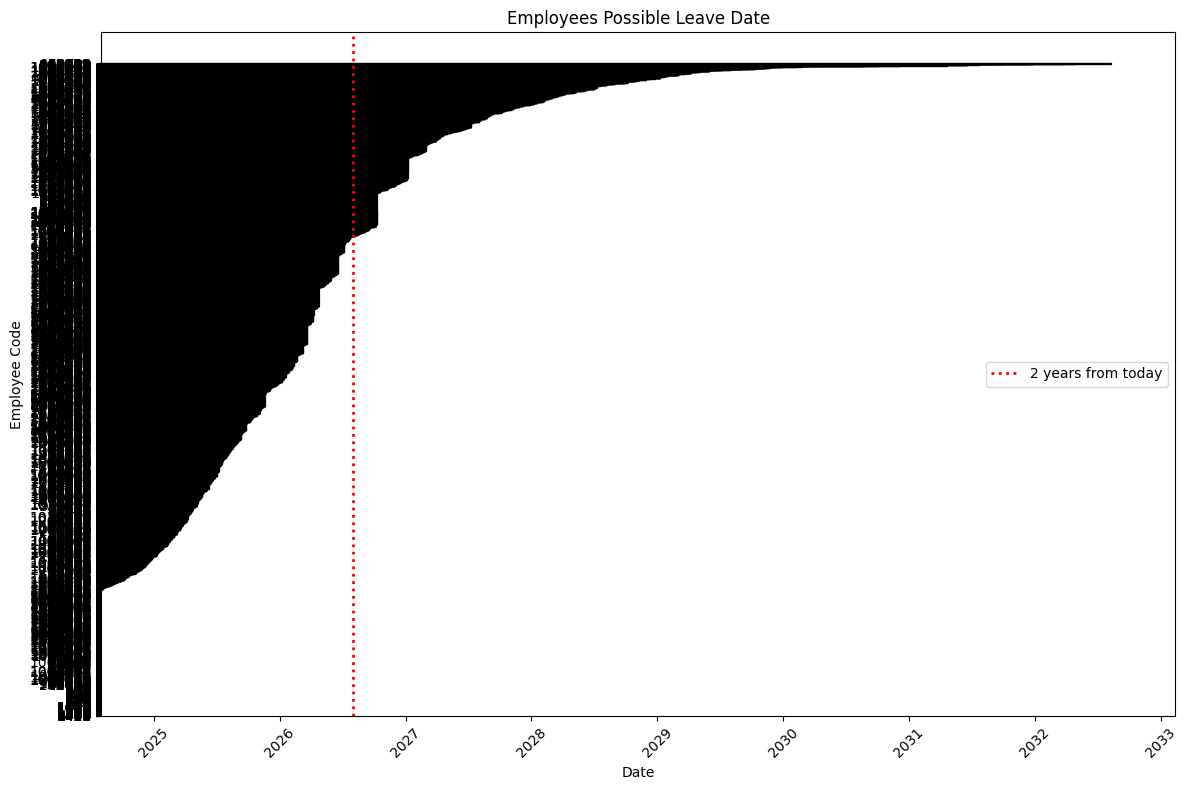

In [6]:


# Ensure 'Possible_Leave_Date' is a datetime object
df_raw['Possible_Leave_Date'] = pd.to_datetime(df_raw['Possible_Leave_Date'])

# Sort the dataframe by 'Possible_Leave_Date' in descending order
df_raw = df_raw.sort_values(by='Possible_Leave_Date', ascending=False)

# Ensure EmployeeID is a string for plotting purposes
df_raw['EmployeeID'] = df_raw['Medewerker_code'].astype(str)

# Get today's date
today = pd.to_datetime('today').normalize()

# Plot
plt.figure(figsize=(12, 8))

# Plot the possible leave date
plt.barh(df_raw['EmployeeID'], df_raw['Possible_Leave_Date'], color='skyblue', edgecolor='black')

# Add a dotted line 2 years from today
two_years_from_today = today + pd.DateOffset(years=2)
plt.axvline(two_years_from_today, color='red', linestyle='dotted', linewidth=2, label='2 years from today')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Employee Code')
plt.title('Employees Possible Leave Date')
plt.xticks(rotation=45)
plt.legend()

# Set the x-axis limits to start from today
plt.xlim([today, df_raw['Possible_Leave_Date'].max() + pd.DateOffset(months=6)])

# Invert y-axis to show descending order
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()
